In [14]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install pytrends

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [20]:
from pytrends.request import TrendReq
import pandas as pd
from IPython.display import display, HTML

# Create pytrends object
pytrend = TrendReq()

# Read keyword input from the user
input_string = input("Enter a Keyword value: ")

# Build payload to get related queries for the main keyword
pytrend.build_payload(kw_list=[input_string], geo='US', timeframe='today 12-m')

# Get related queries for the main keyword
related_queries_main_keyword = pytrend.related_queries().values()

# Extract queries from the dictionary values for the main keyword
queries = []
for query_data in related_queries_main_keyword:
    if query_data['top'] is not None:
        queries.extend(query_data['top']['query'].tolist())

# Define the number of results per batch
results_per_batch = 10

# List to store all related queries
related_queries_for_all = []

# Process queries in batches
for query in queries:
    pytrend.build_payload(kw_list=[query], geo='US', timeframe='today 12-m')
    related_queries = pytrend.related_queries().values()
    for query_data in related_queries:
        if query_data['top'] is not None:
            query_list = query_data['top']['query'].tolist()
            value_list = query_data['top']['value'].tolist()
            for query, value in zip(query_list, value_list):
                # Check if the query already exists in related_queries_for_all
                query_exists = False
                for existing_query in related_queries_for_all:
                    if existing_query['query'] == query:
                        existing_query['value'] += value
                        query_exists = True
                        break
                if not query_exists:
                    related_queries_for_all.append({'query': query, 'value': value})

# Sort the related queries by value in descending order
related_queries_for_all_sorted = sorted(related_queries_for_all, key=lambda x: x['value'], reverse=True)

# Convert the sorted related queries data into a pandas DataFrame
df = pd.DataFrame(related_queries_for_all_sorted)

# Display the DataFrame as a scrollable table
display(HTML(df.to_html()))

# Export data to CSV with user-specified filename
csv_filename = f"{input_string}.csv"
df.to_csv(csv_filename, index=False)
print(f"Data exported to {csv_filename}")


,query,value
0,jobs,1004
1,jobs near me,873
2,part time jobs,447
3,indeed,350
4,remote jobs,321
5,amazon jobs,309
6,jobs hiring,306
7,job near me,235
8,indeed jobs,214
9,hiring near me,191


Data exported to Job.csv


<Figure size 1200x600 with 0 Axes>

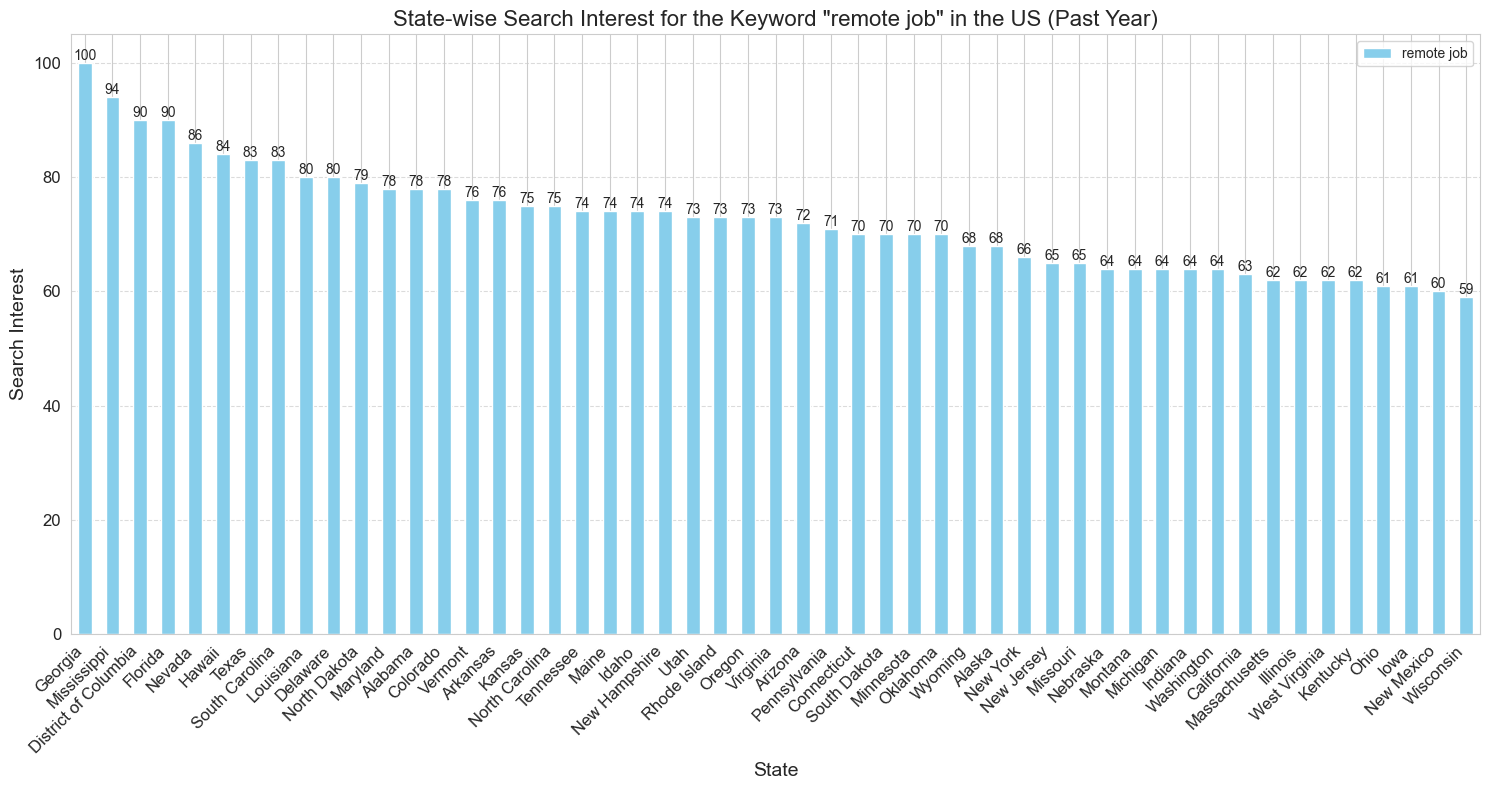

State-wise search interest data exported to remote job_search_interest.csv


In [21]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

# Create pytrends object
pytrend = TrendReq()

# Read keyword input from the user
input_string = input("Enter a Keyword value: ")

# Build payload to get search interest by region
pytrend.build_payload(kw_list=[input_string], geo='US', timeframe='today 12-m')

# Get search interest by region
state_data = pytrend.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False)

# Convert state codes to state names
state_names = []
for code in state_data.index:
    try:
        state_name = pytrend.suggestions(code)[0]['title']
    except IndexError:
        state_name = code  # Use state code if state name not found
    state_names.append(state_name)
state_data['State'] = state_names

# Sort state-wise search interest data by values in descending order
state_data_sorted = state_data.sort_values(by=input_string, ascending=False)

# Plot state-wise keyword search interest
plt.figure(figsize=(12, 6))
ax = state_data_sorted.plot(kind='bar', figsize=(15, 8), color='skyblue')
plt.title(f'State-wise Search Interest for the Keyword "{input_string}" in the US (Past Year)', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Search Interest', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for reference

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Export data to CSV with user-specified filename
csv_filename = f"{input_string}_search_interest.csv"
state_data_sorted.to_csv(csv_filename)
print(f"State-wise search interest data exported to {csv_filename}")


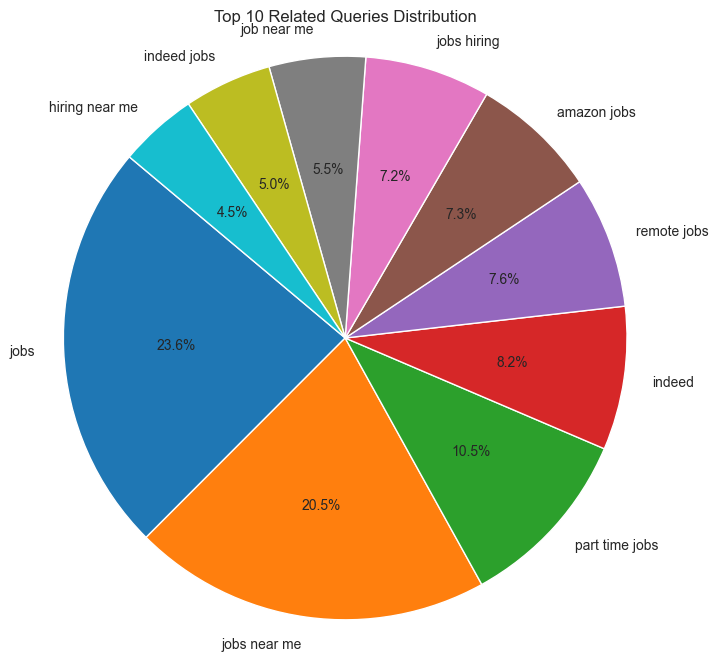

In [22]:
import matplotlib.pyplot as plt

# Convert the sorted related queries data into a pandas DataFrame
df = pd.DataFrame(related_queries_for_all_sorted)

# Display the top 10 related queries
top_10_queries = df.head(10)

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(top_10_queries['value'], labels=top_10_queries['query'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Related Queries Distribution')
plt.axis('equal')
plt.show()


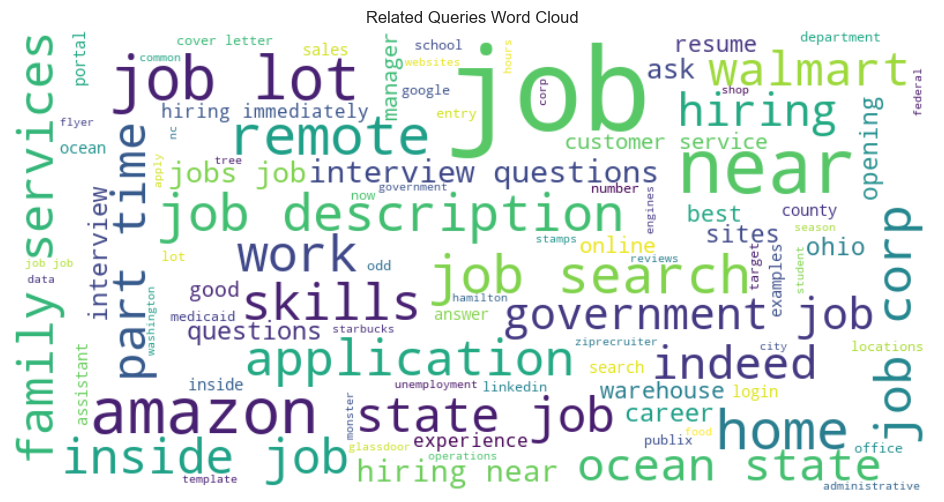

In [23]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert the sorted related queries data into a pandas DataFrame
df = pd.DataFrame(related_queries_for_all_sorted)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',  # color map for the word cloud
    contour_color='steelblue',  # contour color
    contour_width=2,  # contour width
    max_words=100,  # maximum number of words to display
    prefer_horizontal=0.8,  # prefer horizontal orientation of words
    min_font_size=10,  # minimum font size
    max_font_size=100,  # maximum font size
    random_state=42  # random state for reproducibility
).generate(' '.join(df['query']))

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Related Queries Word Cloud')
plt.axis('off')
plt.show()


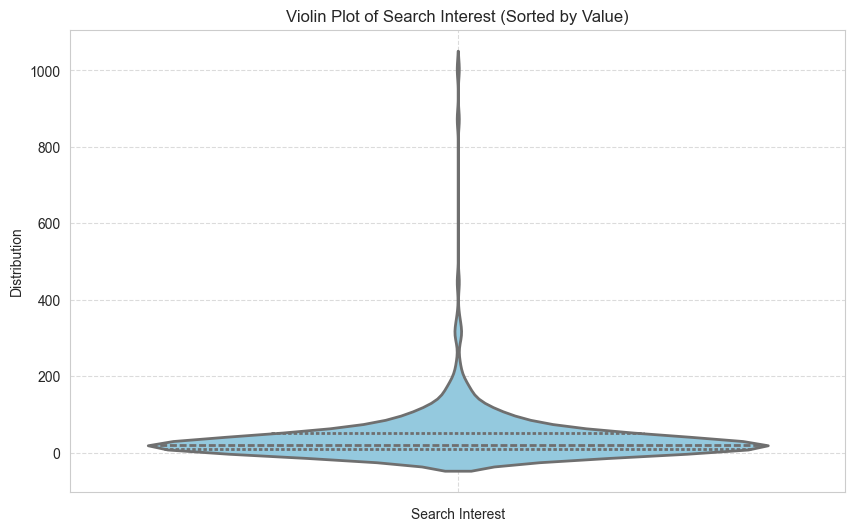

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by the "value" column in descending order
df_sorted = df.sort_values(by='value', ascending=False)

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_sorted, y='value', color='skyblue', linewidth=2, inner='quartile')
plt.title('Violin Plot of Search Interest (Sorted by Value)')
plt.xlabel('Search Interest')
plt.ylabel('Distribution')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


/var/folders/qg/pry90txd3lv0cnsyl7ptwdyh0000gn/T/ipykernel_5919/1835968057.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


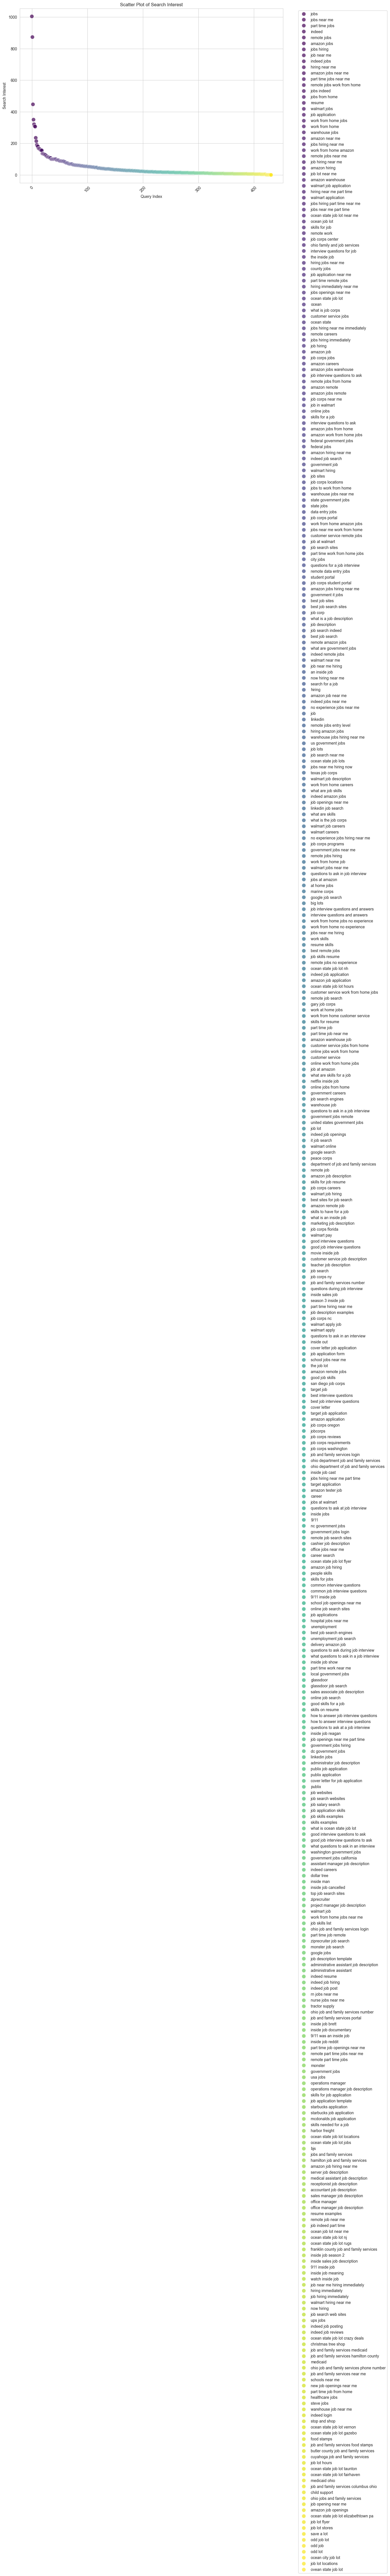

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent color palette
palette = sns.color_palette("viridis", n_colors=len(df))

# Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x=df.index, y='value', hue='query', palette=palette, s=100, alpha=0.7)
plt.title('Scatter Plot of Search Interest')
plt.xlabel('Query Index')
plt.ylabel('Search Interest')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
